In [82]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import numpy as np
import random
from performance_metrics import performance_metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [83]:
data=pd.read_csv('data.txt', sep='\t', index_col=-1)
data.index=pd.to_datetime(data.index)
target_variables = data['tws_csr_interp_lag0']
predictor_variables = data.drop(['tws_csr_interp_lag0'], axis=1)
X = predictor_variables
y = target_variables
# Training on the first half of the data and using the later half for validation
# The idea is to validate against a scenario where the model has not seen the data before
train_size = 0.6
train_index = int(len(data) * train_size)
X_train = np.array(X.iloc[:train_index])
y_train = np.array(y.iloc[:train_index])
X_test = np.array(X.iloc[train_index:])
y_test = np.array(y.iloc[train_index:])
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Initialising a random seed to get reproducible results and hyper-parameter tuning
TUNE = []
seed_value= 81
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=30)
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
# Use the trained model to make predictions on new data
predictions = model.predict(X_test)
# Making y_pred similar to y_test for compatible evaluation in metrics_dict later
custom_y_pred = []
for j in range(len(predictions)):
  custom_y_pred.append(predictions[j][0])
custom_y_pred = np.array(custom_y_pred)
metrics_dict = performance_metrics(y_test, custom_y_pred)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 6, 128)            66560     
                                                                 
 lstm_49 (LSTM)              (None, 64)                49408     
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118081 (461.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 5s 27ms/step - loss: 38.0771
Epoch 2/30
4/4 [==============================] - 0s 27ms/step - l

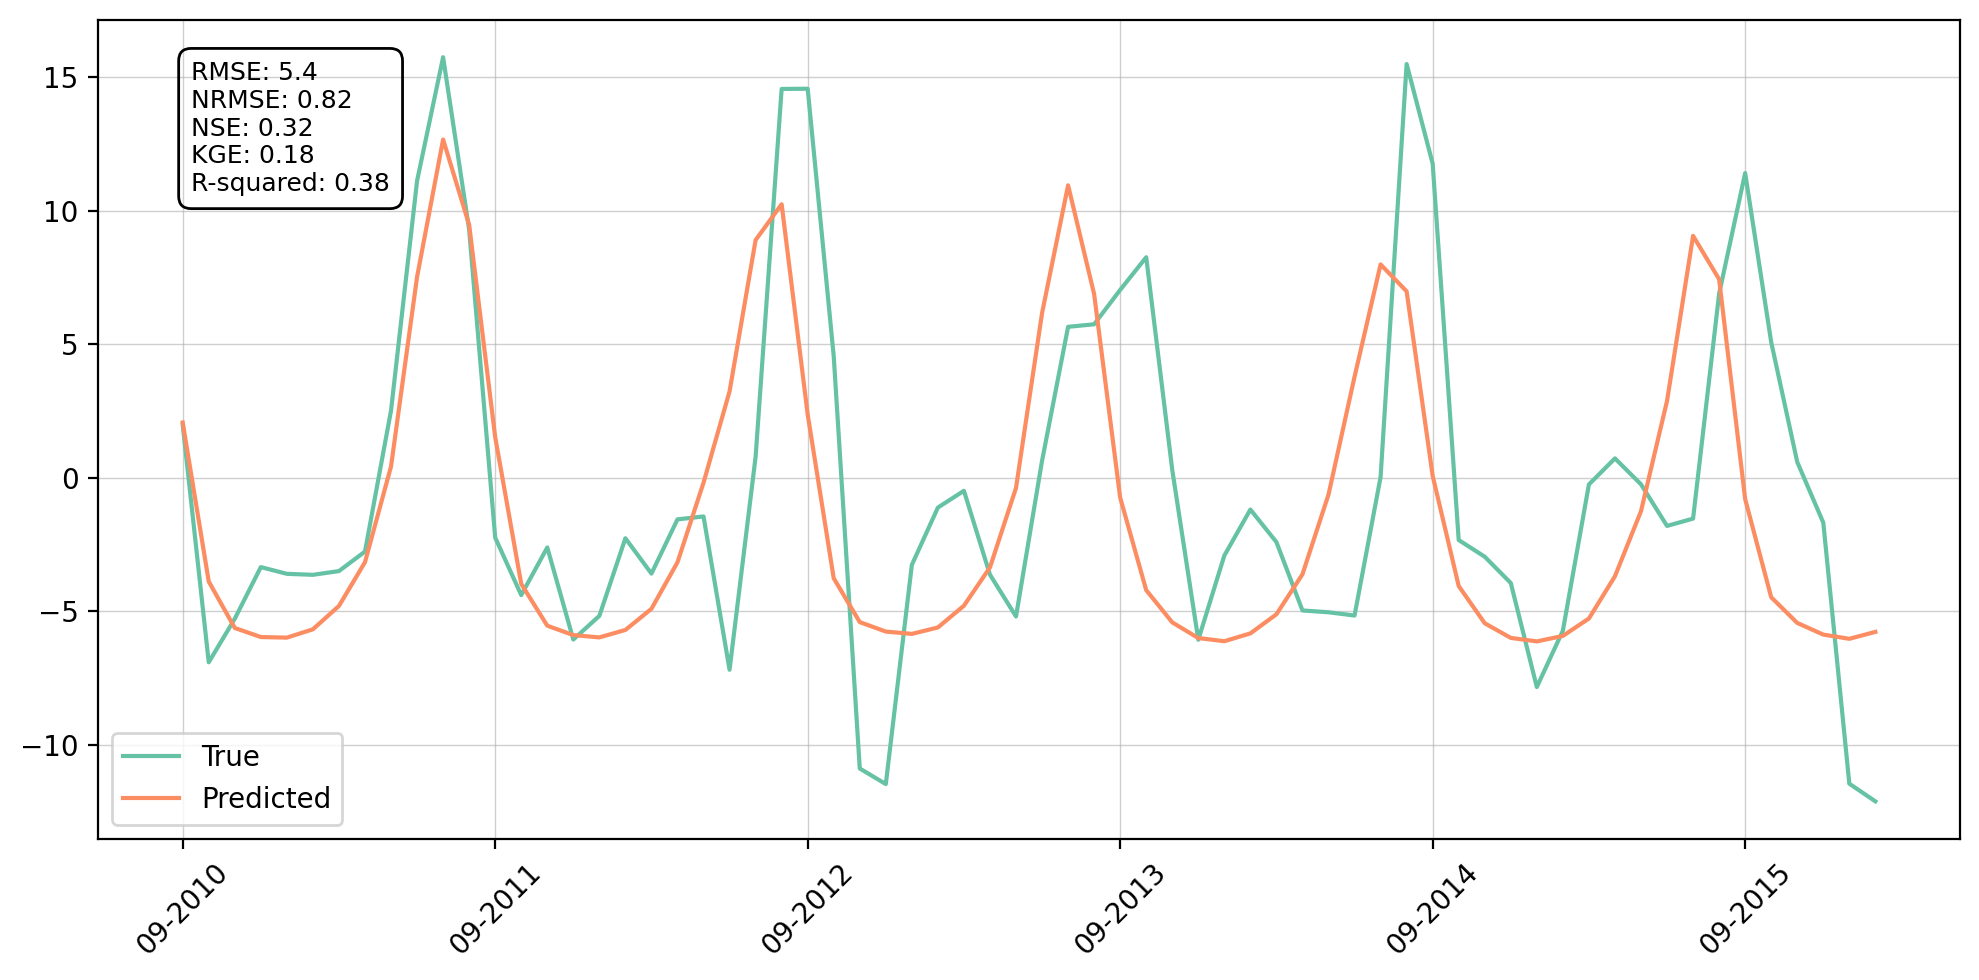

In [84]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.plot(y_test, color='#66c2a5', label='True')
ax.plot(predictions, color='#fc8d62', label='Predicted')
textbox = '\n'.join([f'{key}: {value}' for key, value in metrics_dict.items()])
# Add the metrics_dict as a textbox to the plot
ax.text(0.05, 0.95, textbox, transform=ax.transAxes, fontsize=9,
        verticalalignment='top',
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
# Get the xticks from the dataframe 'data'
xticks = data.index[train_index:]
# Change the format of xticks to mm-yyyy only
xticks = [date.strftime('%m-%Y') for date in xticks]
# Set the xticks on the plot
ax.set_xticks(range(0, len(xticks), 12))
ax.set_xticklabels(xticks[::12], rotation=45)
plt.grid(True, alpha=0.6, lw=0.5)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()